In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import re
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial
import importlib

import timeit
from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

from c1lgkt.jax.fields.equilibrium import Equilibrium
from c1lgkt.jax.fields.geometry_handlers import GeometryHandler, FieldlinePusher

In [4]:
# %% Initialize FieldlinePusher
fieldline_pusher = FieldlinePusher()

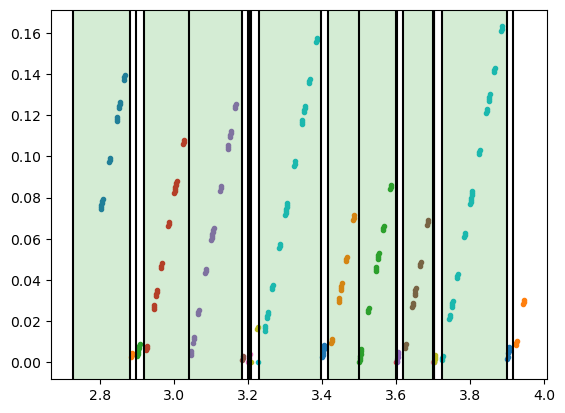

In [16]:
# %% Load TS data from files exported from OMFIT, then find the ELM times

rootdir = R'C:\Users\maple\OneDrive\Research\IFS\Scripts\gpr'

def load_datfile(filename):
    data = dict()

    with open(filename, 'r') as f:
        lines = f.readlines()
        ncol = len(lines[3].split())
        nrow = len(lines)-3

        col_labels = lines[1].split()
        col_units = lines[2].split()

        for c in range(ncol):
            data[col_labels[c]] = np.empty(nrow)

        for k in range(nrow):
            rowdata = list(map(float,lines[k+3].split()))
            for c in range(ncol):
                data[col_labels[c]][k] = rowdata[c]

    return data

data = load_datfile(Rf'{rootdir}\omfit_generated\ws_174864_3370.39.dat')


# Determine the unique values of Z_TS and time
xch, xbins, xcounts = np.unique(data['Z_TS'], return_inverse=True, return_counts=True)
tch, tbins, tcounts = np.unique(data['time'], return_inverse=True, return_counts=True)

# Get time since ELM corresponding to tch
time_since_elm = np.zeros(len(tch))
for k in range(len(tch)):
    time_since_elm[k] = np.average(data['since_ELM'][tbins==k])

# Determine the indices where the time since last ELM decreases
elm_indices = np.where(np.diff(time_since_elm) < np.diff(tch)*0.5)[0]

# Compute the times for the ELMs
t_elms = np.zeros(len(elm_indices)+1)
curr_index = 0
for k in range(len(elm_indices)+1):
    if k == len(elm_indices):
        next_index = -1
    else:
        next_index = elm_indices[k]+1

    t_elms[k] = np.average(tch[curr_index:next_index] - time_since_elm[curr_index:next_index])

    curr_index = next_index

# Determine which ELMs to include
elm_okay = np.diff(t_elms) > 0.05
#elm_whitelist = np.searchsorted(t_elms, [2.96, 3.12, 3.45, 3.56, 3.65]) - 1
#for k in range(len(elm_okay)):
#    if k in elm_whitelist:
#        elm_okay[k] = True
#    else:
#        elm_okay[k] = False

# Plot the ELM times
plt.figure()
curr_index = 0
for k in range(len(elm_indices)+1):
    if k == len(elm_indices):
        next_index = -1
    else:
        next_index = elm_indices[k]+1

    plt.scatter(tch[curr_index:next_index], time_since_elm[curr_index:next_index], marker='.')
    plt.axvline(t_elms[k], c='k')

    if k < len(elm_indices)-1:
        if elm_okay[k]:
            plt.axvspan(t_elms[k], t_elms[k+1], fc='tab:green', alpha=0.2)

    curr_index = next_index

In [6]:
# %% Load equilibrium data and compute q-profiles

times = range(2700, 3900, 10)
eqs = []
geoms = []

# Profiling
start_time = timeit.default_timer()

for time in tqdm(times):
    filename = Rf"{rootdir}\eqs174864\g174864.0{time}"

    eq = Equilibrium.from_gfile(filename)
    geom = GeometryHandler(eq, fieldline_pusher)

    eqs.append(eq)
    geoms.append(geom)

    curr_time = timeit.default_timer()
    print(f"Time for {time}: {curr_time - start_time} seconds")
    start_time = curr_time

    #fieldline_pusher.compute_q_and_dtheta(eq, jnp.linspace(0.1, 0.5, 192))

  0%|          | 0/120 [00:00<?, ?it/s]

Time for 2700: 24.756097399999817 seconds
Time for 2710: 10.87485530000049 seconds
Time for 2720: 6.072279799999706 seconds
Time for 2730: 10.245027800000571 seconds
Time for 2740: 0.5605170999997426 seconds
Time for 2750: 6.1634806000001845 seconds
Time for 2760: 0.49217289999978675 seconds
Time for 2770: 0.4880163999996512 seconds
Time for 2780: 6.210610500000257 seconds
Time for 2790: 0.4444935000001351 seconds
Time for 2800: 0.5323978999995234 seconds
Time for 2810: 0.4628284000000349 seconds
Time for 2820: 0.4711055000007036 seconds
Time for 2830: 0.43253639999966254 seconds
Time for 2840: 0.47178230000008625 seconds
Time for 2850: 0.47723339999993186 seconds
Time for 2860: 0.4384657000000516 seconds
Time for 2870: 0.443785200000093 seconds
Time for 2880: 3.287526899999648 seconds
Time for 2890: 0.5065767000005508 seconds
Time for 2900: 0.6256545999995069 seconds
Time for 2910: 0.6030280000004495 seconds
Time for 2920: 0.4795593999997436 seconds
Time for 2930: 0.5635904000000664 s

In [11]:
t_elms[np.searchsorted(t_elms, 3.0)]

np.float64(3.04056)

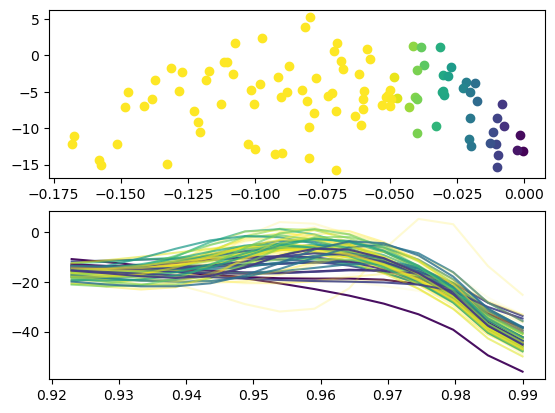

In [21]:
# %% Plot q profiles vs. time to ELM

fig, axs = plt.subplots(2, 1)

for i, time in enumerate(times):
    # Compute time in seconds
    t = time / 1000.0
    # Find index of next ELM
    ind = np.searchsorted(t_elms, t)

    # Check if we're in the whitelist; if so, proceed
    if elm_okay[ind-1]:

        # Get time to next ELM
        to_next_elm = t - t_elms[ind]

        eq = eqs[i]
        geom = geoms[i]

        ind_plot = np.searchsorted(geom.psi_surf/eq.psix, 0.92)

        dq_dpsi = np.gradient(geom.q_surf) / np.gradient(geom.psi_surf / eq.psix)

        color = mpl.cm.viridis(-to_next_elm / 0.05)

        axs[0].scatter(to_next_elm, np.max(dq_dpsi[ind_plot:]), color=color)

        axs[1].plot(geom.psi_surf[ind_plot:]/eq.psix, dq_dpsi[ind_plot:], c=color, alpha=1.0 - np.clip(-to_next_elm / 0.1, 0.0, 1.0))

In [ ]:
# %% Load q profiles from EFIT files

from fileinput import filename


def load_gfile(filename: str):

    with open(filename, 'r') as f:
        data = f.readlines()

        # Start with the first line
        tokens = data[0].split()
        # Get the number of radial and vertical grid points
        Nr = int(tokens[-2])
        Nz = int(tokens[-1])
        Npsi  = Nr

        # Helper function to read a line of tokens
        def read_tokens(line: int):
            return list(map(float,re.findall(r'-?\d\.\d*[eE][-+]\d*', data[line])))

        # The second line contains information for constructing RZ grid
        rdim, zdim, rcentr, rmin, zmid = read_tokens(line=1)
        rmax = rmin + rdim
        zmin = zmid - zdim / 2
        zmax = zmid + zdim / 2

        rgrid = jnp.linspace(rmin, rmax, Nr)
        zgrid = jnp.linspace(zmin, zmax, Nz)

        # The third line contains R,Z of magnetic axis, psi at magnetic axis, and LCFS
        raxis, zaxis, psiaxis, psix, bcentr = tokens = read_tokens(line=2)

        # Out of convenience, renormalize psi such that psiaxis = 0
        psix -= psiaxis
        
        # read EFIT-calculated plasma current, psi at magnetic axis (duplicate),
        # dummy, R of magnetic axis (duplicate), dummy
        ip, _, _, _, _ = read_tokens(line=3)

        # Skip the 5th line
        _, _, _, _, _ = read_tokens(line=4)

        # Start keeping track of the current line
        line = 5

        # Helper function to read arrays
        def read_array(begin_read: int, npts: int):
            # Number of rows to read in an array
            nrows = npts//5
            if npts % 5 != 0:     # catch truncated rows
                nrows += 1

            temp_array = []
            for i in range(nrows):
                temp_array.extend(read_tokens(line=begin_read + i))
            return begin_read + nrows, jnp.array(temp_array)
        
        # First, read in ff
        line, ff = read_array(line, Npsi)
        # Next, read pressure
        line, fluxPres = read_array(line, Npsi)
        # Read ffprim
        line, ffprim = read_array(line, Npsi)
        # Read pprime
        line, pprime = read_array(line, Npsi)

        # psi grid on which the flux functions are defined
        psi = jnp.linspace(0, psix, Npsi)

        # Now, read the 2d psirz array
        line, psirz = read_array(line, Nr * Nz)
        psirz = psirz.reshape((Nz, Nr)) - psiaxis  # renormalize psirz

        # Now read q profile
        line, qpsi = read_array(line, Npsi)

        # Now, we read the LCFS and wall points
        tokens = data[line].split()
        Nlcfs = int(tokens[0])
        Nwall = int(tokens[1])
        line += 1

        line, lcfsrz = read_array(line, 2*Nlcfs)
        lcfsrz = lcfsrz.reshape((Nlcfs, 2)).T
        line, wallrz = read_array(line, 2*Nwall)
        wallrz = wallrz.reshape((Nwall, 2)).T

        # Estimate the X-point location from the LCFS points.
        # TODO: Need to do something about multiple X-points
        zmin_idx = jnp.argmin(lcfsrz[1,:])
        zx = lcfsrz[1, zmin_idx]
        rx = lcfsrz[0, zmin_idx]
    
    return psi, qpsi

times = range(2700, 3900, 10)
psis = []
qpsis = []

for time in times:
    filename = Rf"{rootdir}\eqs174864\g174864.0{time}"

    psi, qpsi = load_gfile(filename)

    psis.append(psi)
    qpsis.append(qpsi)